# Take Home Exam
- By. Job Applicant Byungwoo Kang

---

## Task Objective
- **Generate a prediction model, where target variable is "Installs".**
- Model should be as simple as possible, but not simpler. 
- Given data is not clean. pre-processing (i.e. remove duplicates) might be required.
- Split the data file into 8:2 Train:Validation.
- Score (error metric) is: avg (abs(Log10(Actual) - Log10(Predicted)) )
- If the task description is unclear, you may make your own reasonable assumption. 

## To Do
- Provide the score for the validation set, and explain how you got it.
- 24hr is the official time limit. 8hr should be enough. for any unforeseen incident, you may request for deadline extension.

---

# Import

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') 

import re
import datetime
from dateutil.parser import parse
from copy import deepcopy

from patsy import *
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
import category_encoders as ce
import lightgbm as lgb

In [2]:
df = pd.read_csv("GooglePlay_pion3.csv")
df = df.drop_duplicates()

df.columns = ['app', 'category', 'rating', 'app_size', 'installs',
             'type', 'price', 'content_rating', 'genres',
             'last_updated', 'current_ver', 'android_ver']

In [3]:
df.tail()

,app,category,rating,app_size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
8994,中国語 AQリスニング,FAMILY,NaN,17M,"5,000",Free,0,Everyone,Education,"June 22, 2016",2.4.0,4.0 and up
8995,"乐屋网: Buying a house, selling a house, renting ...",HOUSE_AND_HOME,3.7,15M,"100,000",Free,0,Everyone,House & Home,"August 3, 2018",v3.1.1,4.0 and up
8996,乗換NAVITIME Timetable & Route Search in Japan T...,MAPS_AND_NAVIGATION,4.4,Varies with device,"5,000,000",Free,0,Everyone,Maps & Navigation,"July 26, 2018",Varies with device,Varies with device
8997,日本AV历史,BOOKS_AND_REFERENCE,4.1,30M,"10,000",Free,0,Teen,Books & Reference,"March 6, 2018",1.2,4.0 and up
8998,"漫咖 Comics - Manga,Novel and Stories",COMICS,4.1,21M,"1,000,000",Free,0,Mature 17+,Comics,"July 6, 2018",2.3.1,4.0.3 and up


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7987 entries, 0 to 8998
Data columns (total 12 columns):
app               7987 non-null object
category          7987 non-null object
rating            6954 non-null float64
app_size          7987 non-null object
installs          7987 non-null object
type              7987 non-null object
price             7987 non-null object
content_rating    7987 non-null object
genres            7987 non-null object
last_updated      7987 non-null object
current_ver       7980 non-null object
android_ver       7985 non-null object
dtypes: float64(1), object(11)
memory usage: 811.2+ KB


In [5]:
train = pd.DataFrame()

---

# Pre processing

## Feature engineering

- `genres`를 제외한 Categorical feature는 Ordinal한 성격을 지니고 있다고 판단하여 이에 대한 적절한 전처리를 진행했습니다.
- `genres`는 High cardinality의 성격을 지니고 있으므로, 데이터의 sparsity를 높이기 쉬운 One-hot encoding이 아닌 Target encoding을 적용했습니다.

### installs

- 예측하고자 하는 target으로 App이 다운로드된 횟수를 의미합니다.
- 특수문자 ","가 포함된 문자열 타입이므로 int 형식으로 형변환하는 과정이 필요합니다.

In [6]:
def process_installs(val):
    val = re.sub(",", "", val)
    val = int(val)
    return val

In [7]:
train['installs'] = df.installs.apply(process_installs)
train['installs'] = train['installs'].replace({0: 1}) # log10(0) -> inf 문제 방지

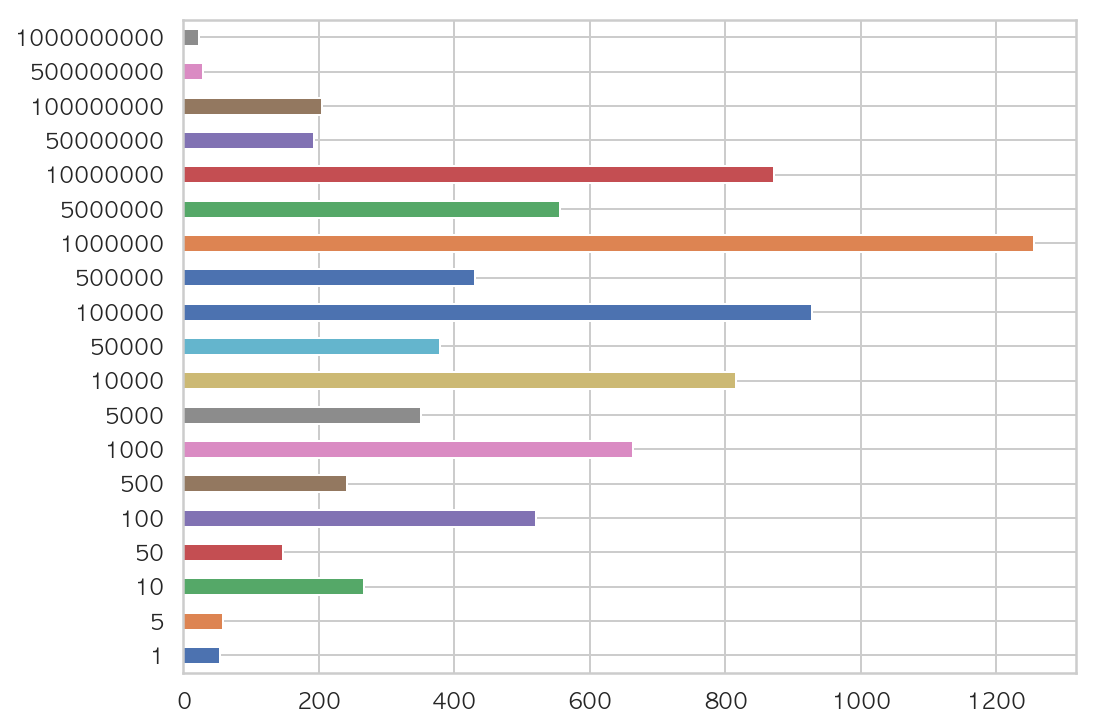

In [8]:
train.installs.value_counts().sort_index().plot(kind='barh', figsize=(8, 6))

---

### app

- 일종의 텍스트 데이터로 유의미한 정보를 추출해보고자 하였으나 언어가 다양하게 나뉘어져 있는 문제가 있습니다.
- 우선 각 데이터의 고유한 id로 간주하고 데이터에서 제외하였습니다.

---

### category
- App store(Google play)의 어플리케이션 카테고리 입니다.
- 후술할 `genres`에서 `category`를 보다 세부적으로 나누고 있으며(특히 `FAMILY`, `GAME`), 중복되는 값이 많으므로 `category`는 train set에서 제외합니다.

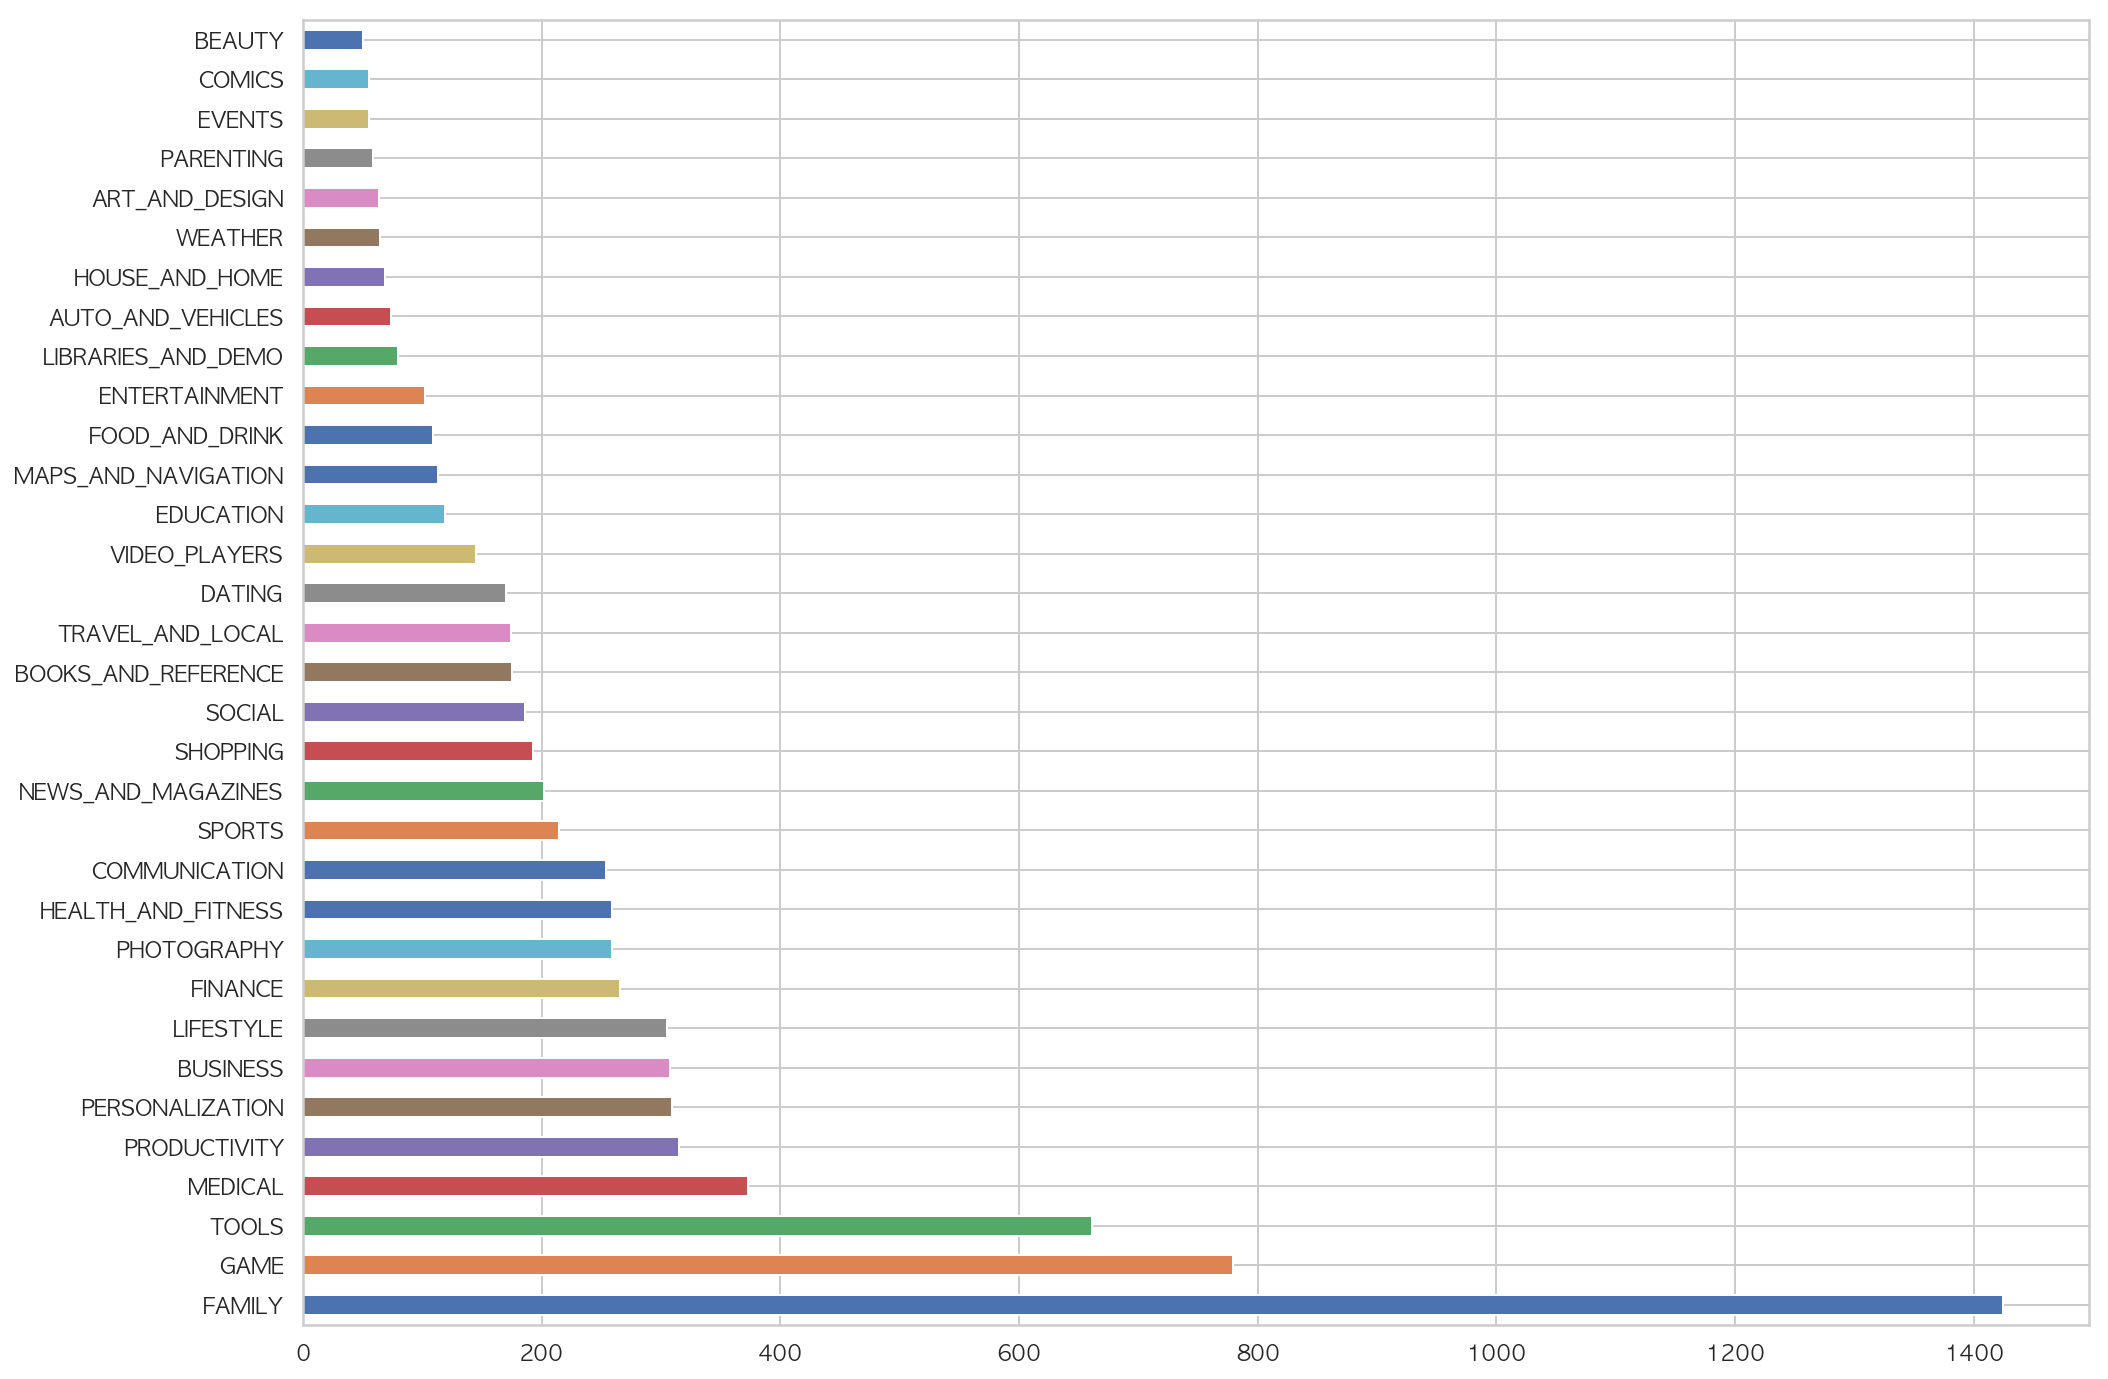

In [9]:
df.category.value_counts().plot(kind='barh', figsize=(16, 12))

---

### rating

- 누락된 rating 값이 0을 의미한다고 할 수 없지만, 우선 ordinal feature의 order를 맞추기 위해 가장 낮은 단계로 가정했습니다.
- 누락 데이터 `no_rating`을 포함한 1, 2, 3, 4의 ordinal category로 전처리합니다.

In [10]:
df.rating.isnull().sum()

1033

In [11]:
train['rating'] = df.rating

#### rating과 installs(target)의 상관관계

In [12]:
train[['rating', 'installs']].corr()

,rating,installs
rating,1.000000,0.044553
installs,0.044553,1.000000


>상관관계가 존재한다고 보기 어렵습니다.

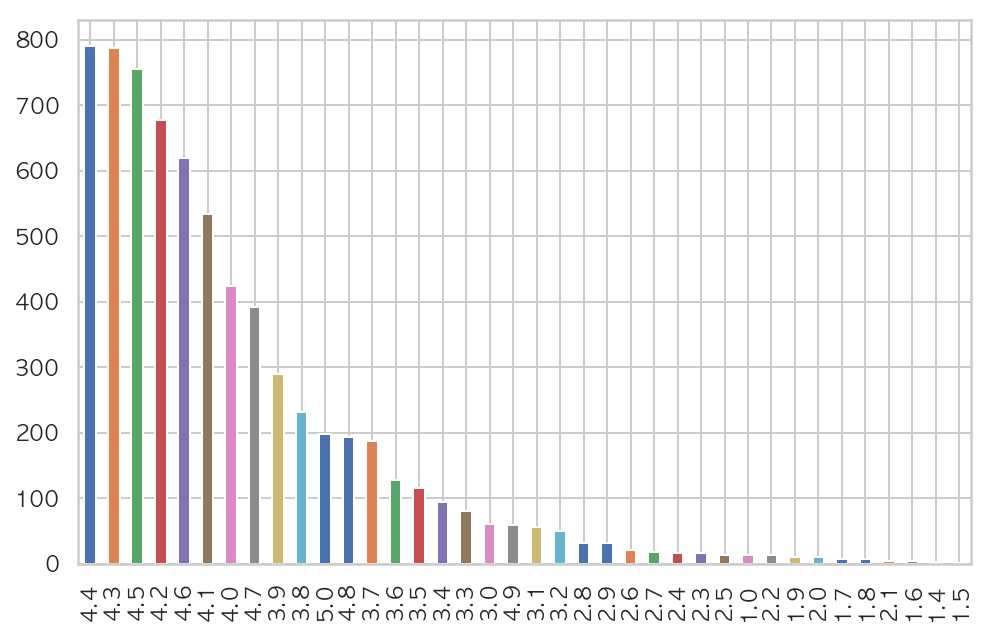

In [13]:
train['rating'].value_counts().plot(kind='bar', figsize=(8, 5))

In [14]:
def process_rating(val):
    rating = 0
    if val > 4:
        rating = 4
    elif 3 < val <= 4:
        rating = 3
    elif 2 < val <= 3:
        rating = 2
    elif 1 < val <= 2:
        rating = 1
    else:
        rating = 0
        
    return rating

In [15]:
train['rating'] = df.rating.apply(process_rating)
train['rating'] = train.rating.astype('category')
train['rating'] = pd.Categorical(train.rating, ordered=True,
                                    categories=[0, 1, 2, 3, 4])

---

### app_size

- 사실상 누락 데이터로 취급해야 하는 `Varies with device` 값이 존재합니다.
- 킬로 바이트(k)와 메가 바이트(M)를 `1MB = 1024kB` 공식에 맞추어 값을 처리한 다음, `Varies with device`를 포함한 oridinal value로 만듭니다.

In [16]:
def process_app_size(val):
    app_size = ""
    if val == "Varies with device":
        app_size = "Varies with device"
    else:
        if val[-1] == "k":
            app_size = float(val[:-1])
        elif val[-1] == "M":
            app_size = val[:-1]
            app_size = float(app_size) * 1024
            
        if 0 <= app_size < 10240:
            app_size = "~10MB"
        elif 10240 <= app_size < 20480:
            app_size = "~20MB"
        elif 20480 <= app_size < 30720:
            app_size = "~30MB"
        elif 30720 <= app_size < 40960:
            app_size = "~40MB"
        elif 40960 <= app_size < 51200:
            app_size = "~50MB"
        elif 51200 <= app_size < 61440:
            app_size = "~60MB"
        elif 61440 <= app_size < 71680:
            app_size = "~70MB"
        elif 71680 <= app_size < 81920:
            app_size = "~80MB"
        elif app_size >= 81920:
            app_size = "80MB~"
            
    return app_size

In [17]:
train['app_size'] = df.app_size.apply(process_app_size)
train['app_size'] = train.app_size.astype("category")

In [18]:
app_size_dict = {"Varies with device" : 0,
                 "~10MB": 1, "~20MB": 2, "~30MB": 3,
                 "~40MB": 4, "~50MB": 5, "~60MB": 6,
                 "~70MB": 7, "~80MB": 8, "80MB~": 9}

train['app_size'] = train.app_size.map(app_size_dict)
train['app_size'] = pd.Categorical(train.app_size, ordered=True,
                                    categories=range(0, 10))

---

### price

`price` 값에서 "$"를 제외한 후 숫자로 형변환합니다.

In [19]:
train['price'] = df['price'].apply(lambda x: "0" if x == "0" else x[1:])
train['price'] = train['price'].astype(np.float16)

---

### type

`price`가 이미 포함하고 있는 정보이므로 훈련용 데이터에서는 제외하겠습니다.

Text(0.5, 1.0, "Rate of 'type'")

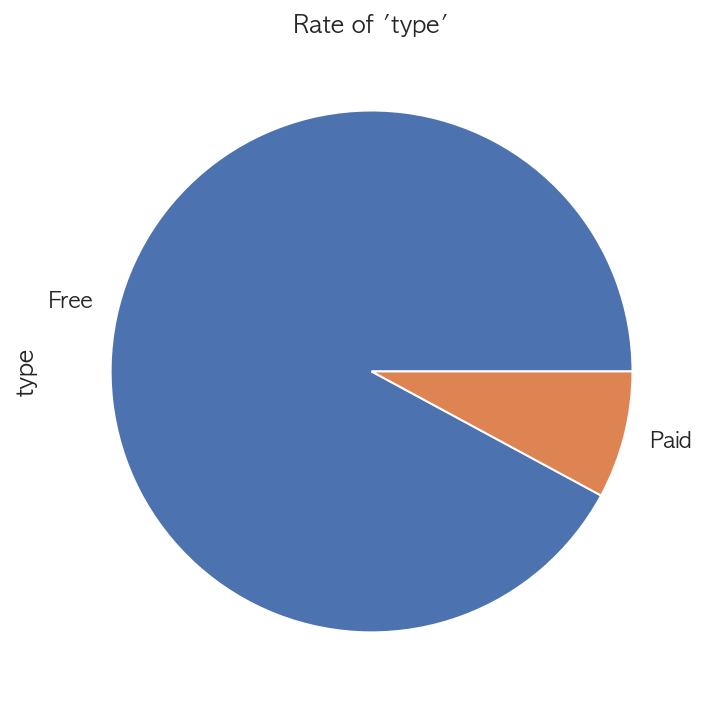

In [20]:
df.type.value_counts().plot(kind='pie', figsize=(6, 6))
plt.title("Rate of 'type'")

---

### content_rating

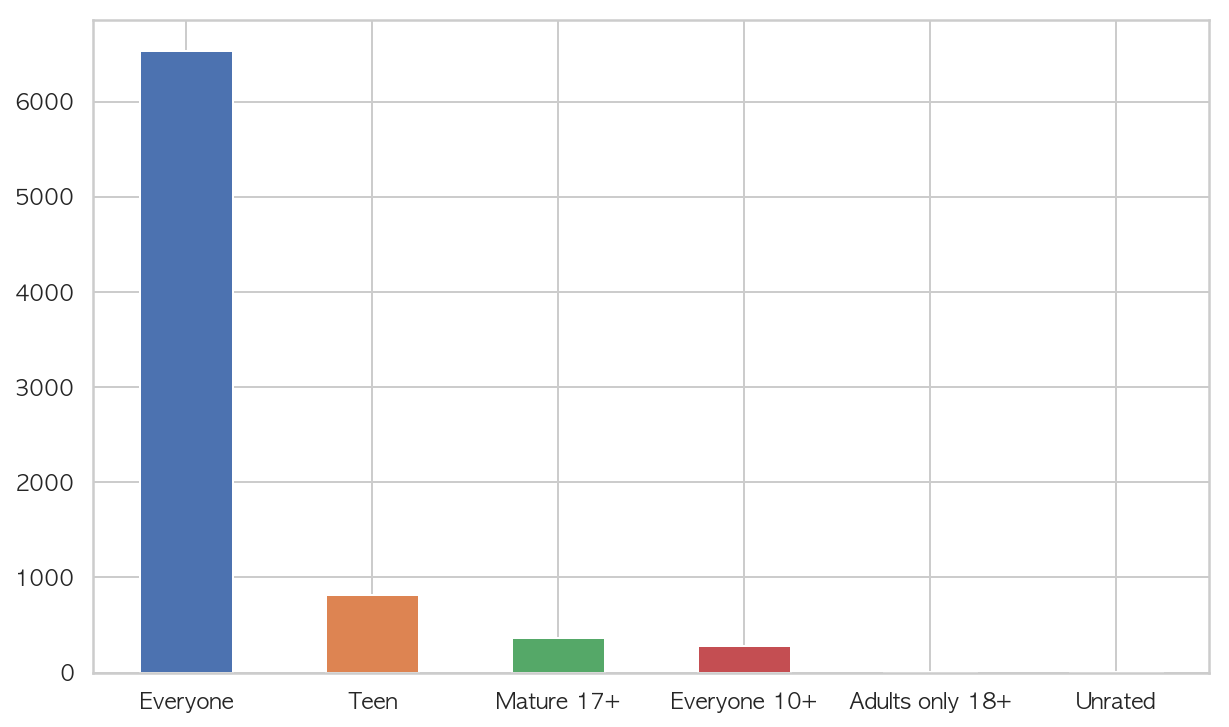

In [21]:
df.content_rating.value_counts().plot(kind='bar', figsize=(10, 6), rot=0)

In [22]:
train['content_rating'] = df.content_rating.astype('category')
content_rating_dict = {'Everyone': 0, 'Everyone 10+': 1, 'Teen': 2, 'Mature 17+': 3,
                       'Adults only 18+': 4, 'Unrated': 5}
train['content_rating'] = train.content_rating.map(content_rating_dict)
train['content_rating'] = pd.Categorical(train.content_rating, ordered=True,
                                         categories=[0, 1, 2, 3, 4, 5])

---

### genres
- `category`를 디테일하게 나누는 hign cardinality feature 입니다.
- feature의 특성을 고려한 categorical encoding이 필요합니다.

In [23]:
print("Number of categories:", len(df.genres.unique()))

Number of categories: 112


In [33]:
train["genres"] = df.genres.astype('category')

---

### last_updated

- 마지막으로 업데이트된 날짜를 나타내는 feature 입니다.
- 날짜 자체가 다운로드 수에 영향을 미치는 것은 아니므로, 최종 업데이트 날짜로부터 현재 시점까지 몇 일이 소요되었는지를 나타내는 feature로 변환했습니다.

In [24]:
def process_last_updated(val):
    now = datetime.datetime.now()
    updated_day = parse(val)
    interval_days = (now - updated_day).days
    
    return interval_days

In [25]:
train["day_after_updated"] = df.last_updated.apply(process_last_updated)
train["day_after_updated"] = train.day_after_updated.astype(np.int16)

---

### current_ver

- App의 업데이트 버전을 의미합니다.
- App을 개발하는 회사마다 버전을 기록하는 방식이 제각각이며, 따라서 버전 번호와 installs 사이에 반드시 양적 상관관계가 존재한다고 판단하기는 어렵습니다.
- 의미를 알 수 없는 문자열 혹은 날짜가 포함된 값이 많습니다.
    - ex) DPSTATUS1.0.1, H7SubTV0.1_TV0.4
- Target인 `installs`에 중요한 영향력을 미치는 것은 현재 버전을 의미하는 숫자 자체가 아니라 App이 꾸준히 업데이트되고 있는지의 여부(`last_updated`)라고 판단하여 train set에서 제외했습니다.

`current_ver`과 `installs` 사이의 상관관계가 존재하는지 간단하게 파악 후 넘어가겠습니다.

In [26]:
df['installs'] = df.installs.apply(process_installs)
corr_df = deepcopy(df)

# "." 이외의 특수문자나 문자열이 포함된 경우는 제외하여 실수형 타입으로 형변환합니다.
def convert_to_num(val):
    try:
        val = float(val)
    except: 
        val = np.nan 
    return val

corr_df['current_ver'] = corr_df['current_ver'].apply(convert_to_num)
corr_df[['installs', 'current_ver']].corr()

,installs,current_ver
installs,1.00000,-0.00437
current_ver,-0.00437,1.00000


>상관계수가 0에 가까운 -0.00437이므로 상관관계가 존재한다고 할 수 없습니다.

---

### android_ver
app 실행을 위해 필요한 Android 버전을 의미합니다.

In [27]:
train["android_ver"] = df.android_ver
train["android_ver"].fillna('Varies with device', inplace=True)

In [28]:
d = {"4.0.3 - 7.1.1": "4.0.3 and up",
     "4.1 - 7.1.1": "4.1 and up",
     "5.0 - 6.0": "5.0 and up",
     "5.0 - 8.0": "5.0 and up",
     "7.0 - 7.1.1": "7.0 and up"}

train["android_ver"] = train.android_ver.replace(d)
train["android_ver"] = train.android_ver.astype('category')

In [29]:
android_ver_dict = {"Varies with device": 0,
                    "1.0 and up": 1, 
                    "1.5 and up": 2,
                    "1.6 and up": 3,
                    "2.0 and up": 4,
                    "2.0.1 and up": 5,
                    "2.1 and up": 6,
                    "2.2 and up": 7,
                    "2.3 and up": 8,
                    "2.3.3 and up": 9,
                    "3.0 and up": 10,
                    "3.1 and up": 11,
                    "3.2 and up": 12,
                    "4.0 and up": 13,
                    "4.0.3 and up": 14,
                    "4.1 and up": 15,
                    "4.2 and up": 16,
                    "4.3 and up": 17,
                    "4.4 and up": 18,
                    "4.4W and up": 19,
                    "5.0 and up": 20,
                    "5.1 and up": 21,
                    "6.0 and up": 22,
                    "7.0 and up": 23,
                    "7.1 and up": 24,
                    "8.0 and up": 25}

train["android_ver"] = train.android_ver.map(android_ver_dict)
train["android_ver"] = pd.Categorical(train.android_ver, ordered=True,
                                      categories=range(0, 26))

---

# Modeling
- Linear regression
- Random forest regression
- Gradient boosting regression

## Metric

>`avg(abs(Log10(Actual) - Log10(Predicted)))`

Target에 `np.log10` transformation을 적용한 mean absolute error입니다.

In [30]:
def metric(actual, predicted):
    error = abs(actual - predicted)
    return np.mean(error)

---

## Train Test Split
- 데이터를 8:2 비율의 Train:Validation set으로 나눕니다.

In [34]:
X = train[['rating', 'app_size', 'price', 'content_rating',
           'genres', 'day_after_updated', 'android_ver']]

y = np.log10(train['installs']) # np.log10 transformation

In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

---

## `genres` -> Target encoding
- 카테고리의 수가 많은 High cardinality feature에 효과적인 카테고리 인코딩 입니다.
- Categorical feature를 카테고리 단위로 groupby 하여 target에 대한 평균값으로 연산하는 방식입니다.
- Label encoding과 달리 Target값과 직접적인 연관성을 반영할 수 있는 장점이 있습니다.

In [42]:
cols = ['genres']
encoder = ce.TargetEncoder(cols=cols)

In [43]:
X_train = encoder.fit_transform(X_train, y_train)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

encoded_train = pd.concat([X_train, y_train], axis=1)

In [44]:
X_val = encoder.transform(X_val, y_val)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

encoded_val = pd.concat([X_val, y_val], axis=1)

---

## Linear regression
- 저조한 수준의 R-squared score가 나왔습니다.
- 데이터 셋의 구조가 선형 회귀분석에 적합하지 않은 상태라고 판단되며, Ordinal feature 처리를 위해서 Polynomial transformation을 가했기 때문에 각 feature 사이의 영향력을 비교 분석하기에는 무리가 있습니다.
- 시간 문제 상 직접 시도해보지는 못했지만, Linear regression 모델에서는 Categorical feature들을 One-hot encoding하는 경우가 분석에 보다 편리하며 더 좋은 성과가 나올 것으로 예상됩니다.
    - (이번 프로젝트에서는 Tree-based model을 사용할 것을 고려하여 One-hot encoding을 최대한 배제했습니다.

In [45]:
lm = sm.OLS.from_formula("installs ~ C(rating, Poly) + scale(price) + C(app_size, Poly) \
                          + scale(content_rating, Poly) + genres + scale(day_after_updated) \
                          + C(android_ver, Poly)", data=encoded_train)

lm_result = lm.fit()
print(lm_result.summary())

                            OLS Regression Results                            
Dep. Variable:               installs   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     172.8
Date:                Mon, 15 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:28:52   Log-Likelihood:                -10709.
No. Observations:                6389   AIC:                         2.150e+04
Df Residuals:                    6346   BIC:                         2.180e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [46]:
lm_pred = lm_result.predict(X_val)

In [47]:
print("Score(error metric) is:", metric(y_val, lm_pred))

Score(error metric) is: 1.0872570320699773


### 잔차 정규성
- Q-Q plot 확인 결과, 잔차의 정규성이 지켜지지 않았습니다.

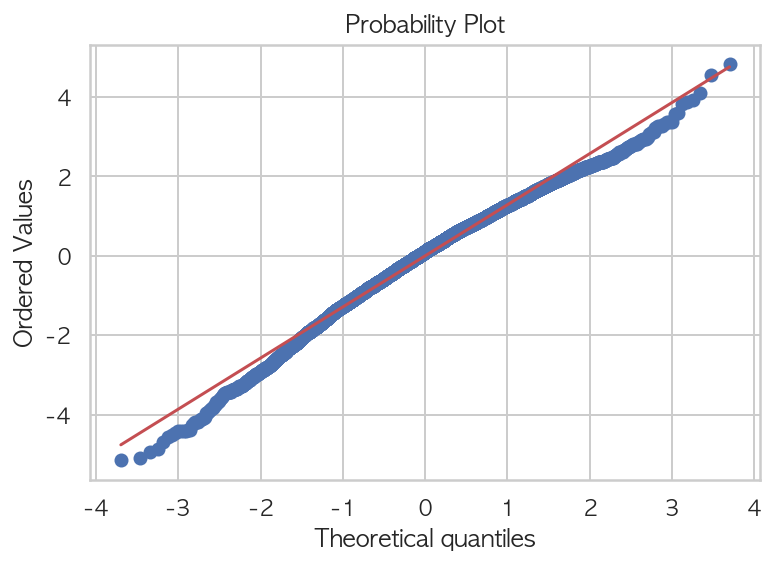

In [48]:
sp.stats.probplot(lm_result.resid, plot=plt)
plt.show()

---

## Random forest regressor
- 성능 향상을 위하여 Tree-based의 Ensemble model을 사용합니다.

In [49]:
regr = RandomForestRegressor(n_estimators=256,
                             criterion='mae', 
                             max_features=0.9,
                             random_state=42)

In [50]:
%%time
rfm = regr.fit(X_train, y_train)

#### Check overfitting
- k-fold: 5

In [51]:
%%time
cross_val_score(rfm, X_train, y_train, cv=5)

array([0.62160476, 0.56475437, 0.60766417, 0.63216565, 0.62069315])

#### metric
- validation set을 기준으로 평가해야 합니다.

In [52]:
rfm_pred = rfm.predict(X_val)

In [53]:
print("Score(error metric) is:", metric(y_val, rfm_pred))

Score(error metric) is: 0.9265181261376967


#### Feature importance
Tree 구조의 모델에서 어떠한 Feature가 모델의 엔트로피를 낮추는데 공헌하는지(=information gain을 높이는지)를 기준으로 중요도를 계산합니다.

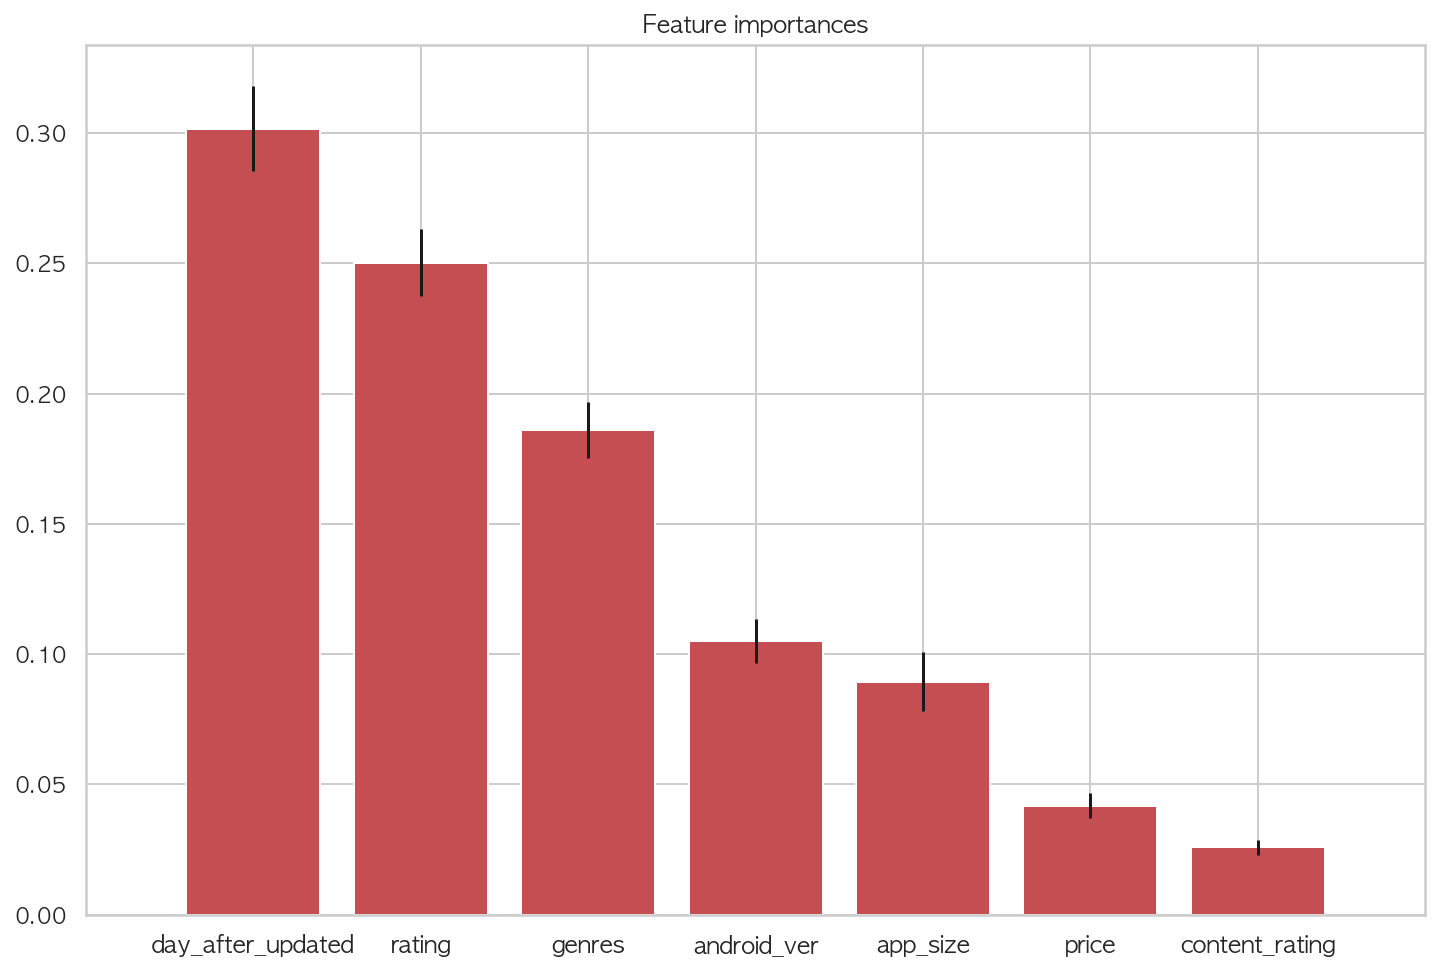

In [54]:
importances = rfm.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfm.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature importances")
plt.bar(range(X_val.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_val.shape[1]), X_val.columns[indices], fontsize=12)
plt.xlim([-1, X_val.shape[1]])
plt.show()

>Feature 중 `day_after_updated`가 가장 높은 Feature importance 수치를 나타냈습니다.

---

## Gradient Boosting Regressor
- Ensemble model 중 LightGBM 패키지를 활용한 boosting 모델도 적용해보았습니다.

In [55]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [56]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'max_depth': 4,
    'num_leaves': 12,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'random_seed': 42
}

In [57]:
%%time
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=930108,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

[1]	valid_0's l2: 3.63966
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l2: 3.6375
[3]	valid_0's l2: 3.63386
[4]	valid_0's l2: 3.63041
[5]	valid_0's l2: 3.62691
[6]	valid_0's l2: 3.62337
[7]	valid_0's l2: 3.61977
[8]	valid_0's l2: 3.61618
[9]	valid_0's l2: 3.61266
[10]	valid_0's l2: 3.60918
[11]	valid_0's l2: 3.60565
[12]	valid_0's l2: 3.60212
[13]	valid_0's l2: 3.60008
[14]	valid_0's l2: 3.59668
[15]	valid_0's l2: 3.59317
[16]	valid_0's l2: 3.58962
[17]	valid_0's l2: 3.58625
[18]	valid_0's l2: 3.58271
[19]	valid_0's l2: 3.57927
[20]	valid_0's l2: 3.57576
[21]	valid_0's l2: 3.57238
[22]	valid_0's l2: 3.56908
[23]	valid_0's l2: 3.56578
[24]	valid_0's l2: 3.56235
[25]	valid_0's l2: 3.55907
[26]	valid_0's l2: 3.55569
[27]	valid_0's l2: 3.55223
[28]	valid_0's l2: 3.55018
[29]	valid_0's l2: 3.54673
[30]	valid_0's l2: 3.54334
[31]	valid_0's l2: 3.53993
[32]	valid_0's l2: 3.53648
[33]	valid_0's l2: 3.5331
[34]	valid_0's l2: 3.52972
[35]	valid_0's l2: 3.52629
[36]

[355]	valid_0's l2: 2.74215
[356]	valid_0's l2: 2.74021
[357]	valid_0's l2: 2.73817
[358]	valid_0's l2: 2.73624
[359]	valid_0's l2: 2.73421
[360]	valid_0's l2: 2.73219
[361]	valid_0's l2: 2.73027
[362]	valid_0's l2: 2.72829
[363]	valid_0's l2: 2.72627
[364]	valid_0's l2: 2.72429
[365]	valid_0's l2: 2.72232
[366]	valid_0's l2: 2.72031
[367]	valid_0's l2: 2.71829
[368]	valid_0's l2: 2.71628
[369]	valid_0's l2: 2.71511
[370]	valid_0's l2: 2.71394
[371]	valid_0's l2: 2.71198
[372]	valid_0's l2: 2.71012
[373]	valid_0's l2: 2.70826
[374]	valid_0's l2: 2.70629
[375]	valid_0's l2: 2.70444
[376]	valid_0's l2: 2.70252
[377]	valid_0's l2: 2.70057
[378]	valid_0's l2: 2.69863
[379]	valid_0's l2: 2.69669
[380]	valid_0's l2: 2.69475
[381]	valid_0's l2: 2.69359
[382]	valid_0's l2: 2.69243
[383]	valid_0's l2: 2.69055
[384]	valid_0's l2: 2.68858
[385]	valid_0's l2: 2.68662
[386]	valid_0's l2: 2.68466
[387]	valid_0's l2: 2.68282
[388]	valid_0's l2: 2.68088
[389]	valid_0's l2: 2.67902
[390]	valid_0's l2: 

[674]	valid_0's l2: 2.27433
[675]	valid_0's l2: 2.27324
[676]	valid_0's l2: 2.2721
[677]	valid_0's l2: 2.27089
[678]	valid_0's l2: 2.26968
[679]	valid_0's l2: 2.26851
[680]	valid_0's l2: 2.26734
[681]	valid_0's l2: 2.26613
[682]	valid_0's l2: 2.26492
[683]	valid_0's l2: 2.26378
[684]	valid_0's l2: 2.26257
[685]	valid_0's l2: 2.26135
[686]	valid_0's l2: 2.26023
[687]	valid_0's l2: 2.25908
[688]	valid_0's l2: 2.25789
[689]	valid_0's l2: 2.25671
[690]	valid_0's l2: 2.25559
[691]	valid_0's l2: 2.25487
[692]	valid_0's l2: 2.25371
[693]	valid_0's l2: 2.25254
[694]	valid_0's l2: 2.25139
[695]	valid_0's l2: 2.25067
[696]	valid_0's l2: 2.2495
[697]	valid_0's l2: 2.24837
[698]	valid_0's l2: 2.24724
[699]	valid_0's l2: 2.24607
[700]	valid_0's l2: 2.24488
[701]	valid_0's l2: 2.24372
[702]	valid_0's l2: 2.24257
[703]	valid_0's l2: 2.24186
[704]	valid_0's l2: 2.24075
[705]	valid_0's l2: 2.23959
[706]	valid_0's l2: 2.23852
[707]	valid_0's l2: 2.23746
[708]	valid_0's l2: 2.23632
[709]	valid_0's l2: 2.

[1034]	valid_0's l2: 1.96413
[1035]	valid_0's l2: 1.96346
[1036]	valid_0's l2: 1.96276
[1037]	valid_0's l2: 1.96209
[1038]	valid_0's l2: 1.96139
[1039]	valid_0's l2: 1.96076
[1040]	valid_0's l2: 1.96013
[1041]	valid_0's l2: 1.95945
[1042]	valid_0's l2: 1.95881
[1043]	valid_0's l2: 1.95814
[1044]	valid_0's l2: 1.95772
[1045]	valid_0's l2: 1.95703
[1046]	valid_0's l2: 1.95642
[1047]	valid_0's l2: 1.95576
[1048]	valid_0's l2: 1.95507
[1049]	valid_0's l2: 1.95441
[1050]	valid_0's l2: 1.95373
[1051]	valid_0's l2: 1.95309
[1052]	valid_0's l2: 1.95242
[1053]	valid_0's l2: 1.95175
[1054]	valid_0's l2: 1.95108
[1055]	valid_0's l2: 1.95042
[1056]	valid_0's l2: 1.94976
[1057]	valid_0's l2: 1.9491
[1058]	valid_0's l2: 1.94846
[1059]	valid_0's l2: 1.9478
[1060]	valid_0's l2: 1.94714
[1061]	valid_0's l2: 1.9465
[1062]	valid_0's l2: 1.94613
[1063]	valid_0's l2: 1.9455
[1064]	valid_0's l2: 1.94486
[1065]	valid_0's l2: 1.94424
[1066]	valid_0's l2: 1.94361
[1067]	valid_0's l2: 1.94299
[1068]	valid_0's l

[1339]	valid_0's l2: 1.81108
[1340]	valid_0's l2: 1.81079
[1341]	valid_0's l2: 1.8104
[1342]	valid_0's l2: 1.81012
[1343]	valid_0's l2: 1.80974
[1344]	valid_0's l2: 1.80945
[1345]	valid_0's l2: 1.80902
[1346]	valid_0's l2: 1.8086
[1347]	valid_0's l2: 1.80819
[1348]	valid_0's l2: 1.80776
[1349]	valid_0's l2: 1.80747
[1350]	valid_0's l2: 1.80708
[1351]	valid_0's l2: 1.80682
[1352]	valid_0's l2: 1.80641
[1353]	valid_0's l2: 1.80602
[1354]	valid_0's l2: 1.80563
[1355]	valid_0's l2: 1.80525
[1356]	valid_0's l2: 1.80484
[1357]	valid_0's l2: 1.80445
[1358]	valid_0's l2: 1.80402
[1359]	valid_0's l2: 1.80362
[1360]	valid_0's l2: 1.80322
[1361]	valid_0's l2: 1.80282
[1362]	valid_0's l2: 1.80242
[1363]	valid_0's l2: 1.80202
[1364]	valid_0's l2: 1.80161
[1365]	valid_0's l2: 1.8012
[1366]	valid_0's l2: 1.80081
[1367]	valid_0's l2: 1.8004
[1368]	valid_0's l2: 1.8
[1369]	valid_0's l2: 1.79961
[1370]	valid_0's l2: 1.79921
[1371]	valid_0's l2: 1.79884
[1372]	valid_0's l2: 1.79843
[1373]	valid_0's l2: 1

[1679]	valid_0's l2: 1.70436
[1680]	valid_0's l2: 1.70411
[1681]	valid_0's l2: 1.70387
[1682]	valid_0's l2: 1.70362
[1683]	valid_0's l2: 1.70341
[1684]	valid_0's l2: 1.70319
[1685]	valid_0's l2: 1.70294
[1686]	valid_0's l2: 1.70269
[1687]	valid_0's l2: 1.70247
[1688]	valid_0's l2: 1.70224
[1689]	valid_0's l2: 1.70202
[1690]	valid_0's l2: 1.70178
[1691]	valid_0's l2: 1.70155
[1692]	valid_0's l2: 1.70131
[1693]	valid_0's l2: 1.70108
[1694]	valid_0's l2: 1.70085
[1695]	valid_0's l2: 1.70059
[1696]	valid_0's l2: 1.70033
[1697]	valid_0's l2: 1.70005
[1698]	valid_0's l2: 1.69979
[1699]	valid_0's l2: 1.69953
[1700]	valid_0's l2: 1.69927
[1701]	valid_0's l2: 1.69901
[1702]	valid_0's l2: 1.69875
[1703]	valid_0's l2: 1.69848
[1704]	valid_0's l2: 1.69831
[1705]	valid_0's l2: 1.69808
[1706]	valid_0's l2: 1.6979
[1707]	valid_0's l2: 1.69764
[1708]	valid_0's l2: 1.69739
[1709]	valid_0's l2: 1.69714
[1710]	valid_0's l2: 1.69688
[1711]	valid_0's l2: 1.69664
[1712]	valid_0's l2: 1.69641
[1713]	valid_0'

[2209]	valid_0's l2: 1.61321
[2210]	valid_0's l2: 1.6131
[2211]	valid_0's l2: 1.61295
[2212]	valid_0's l2: 1.61283
[2213]	valid_0's l2: 1.61271
[2214]	valid_0's l2: 1.6126
[2215]	valid_0's l2: 1.61248
[2216]	valid_0's l2: 1.61236
[2217]	valid_0's l2: 1.61225
[2218]	valid_0's l2: 1.61213
[2219]	valid_0's l2: 1.61202
[2220]	valid_0's l2: 1.61189
[2221]	valid_0's l2: 1.61175
[2222]	valid_0's l2: 1.61162
[2223]	valid_0's l2: 1.61148
[2224]	valid_0's l2: 1.61137
[2225]	valid_0's l2: 1.61126
[2226]	valid_0's l2: 1.61112
[2227]	valid_0's l2: 1.61099
[2228]	valid_0's l2: 1.61088
[2229]	valid_0's l2: 1.61078
[2230]	valid_0's l2: 1.61067
[2231]	valid_0's l2: 1.61052
[2232]	valid_0's l2: 1.61038
[2233]	valid_0's l2: 1.61024
[2234]	valid_0's l2: 1.61016
[2235]	valid_0's l2: 1.61003
[2236]	valid_0's l2: 1.6099
[2237]	valid_0's l2: 1.6098
[2238]	valid_0's l2: 1.60969
[2239]	valid_0's l2: 1.6096
[2240]	valid_0's l2: 1.6095
[2241]	valid_0's l2: 1.60936
[2242]	valid_0's l2: 1.60923
[2243]	valid_0's l2:

[2521]	valid_0's l2: 1.58121
[2522]	valid_0's l2: 1.58113
[2523]	valid_0's l2: 1.58106
[2524]	valid_0's l2: 1.58098
[2525]	valid_0's l2: 1.58091
[2526]	valid_0's l2: 1.58082
[2527]	valid_0's l2: 1.58073
[2528]	valid_0's l2: 1.58064
[2529]	valid_0's l2: 1.58055
[2530]	valid_0's l2: 1.58046
[2531]	valid_0's l2: 1.58038
[2532]	valid_0's l2: 1.5803
[2533]	valid_0's l2: 1.58021
[2534]	valid_0's l2: 1.58012
[2535]	valid_0's l2: 1.58004
[2536]	valid_0's l2: 1.57997
[2537]	valid_0's l2: 1.5799
[2538]	valid_0's l2: 1.57982
[2539]	valid_0's l2: 1.57974
[2540]	valid_0's l2: 1.57966
[2541]	valid_0's l2: 1.57959
[2542]	valid_0's l2: 1.57949
[2543]	valid_0's l2: 1.57942
[2544]	valid_0's l2: 1.57934
[2545]	valid_0's l2: 1.57924
[2546]	valid_0's l2: 1.57916
[2547]	valid_0's l2: 1.57907
[2548]	valid_0's l2: 1.57899
[2549]	valid_0's l2: 1.57891
[2550]	valid_0's l2: 1.57882
[2551]	valid_0's l2: 1.57875
[2552]	valid_0's l2: 1.57868
[2553]	valid_0's l2: 1.57859
[2554]	valid_0's l2: 1.57851
[2555]	valid_0's

[2842]	valid_0's l2: 1.55858
[2843]	valid_0's l2: 1.55853
[2844]	valid_0's l2: 1.55847
[2845]	valid_0's l2: 1.55841
[2846]	valid_0's l2: 1.55836
[2847]	valid_0's l2: 1.5583
[2848]	valid_0's l2: 1.55825
[2849]	valid_0's l2: 1.5582
[2850]	valid_0's l2: 1.55815
[2851]	valid_0's l2: 1.55811
[2852]	valid_0's l2: 1.55808
[2853]	valid_0's l2: 1.55803
[2854]	valid_0's l2: 1.55799
[2855]	valid_0's l2: 1.55795
[2856]	valid_0's l2: 1.5579
[2857]	valid_0's l2: 1.55784
[2858]	valid_0's l2: 1.55779
[2859]	valid_0's l2: 1.55773
[2860]	valid_0's l2: 1.55767
[2861]	valid_0's l2: 1.55761
[2862]	valid_0's l2: 1.55756
[2863]	valid_0's l2: 1.55751
[2864]	valid_0's l2: 1.55747
[2865]	valid_0's l2: 1.55741
[2866]	valid_0's l2: 1.55736
[2867]	valid_0's l2: 1.55732
[2868]	valid_0's l2: 1.55728
[2869]	valid_0's l2: 1.55723
[2870]	valid_0's l2: 1.55718
[2871]	valid_0's l2: 1.55713
[2872]	valid_0's l2: 1.55706
[2873]	valid_0's l2: 1.557
[2874]	valid_0's l2: 1.55695
[2875]	valid_0's l2: 1.55688
[2876]	valid_0's l2

[3136]	valid_0's l2: 1.54478
[3137]	valid_0's l2: 1.54473
[3138]	valid_0's l2: 1.54468
[3139]	valid_0's l2: 1.54463
[3140]	valid_0's l2: 1.54459
[3141]	valid_0's l2: 1.54455
[3142]	valid_0's l2: 1.5445
[3143]	valid_0's l2: 1.54444
[3144]	valid_0's l2: 1.54438
[3145]	valid_0's l2: 1.54432
[3146]	valid_0's l2: 1.54427
[3147]	valid_0's l2: 1.54423
[3148]	valid_0's l2: 1.54419
[3149]	valid_0's l2: 1.54413
[3150]	valid_0's l2: 1.54408
[3151]	valid_0's l2: 1.54404
[3152]	valid_0's l2: 1.54401
[3153]	valid_0's l2: 1.54397
[3154]	valid_0's l2: 1.54393
[3155]	valid_0's l2: 1.54389
[3156]	valid_0's l2: 1.54385
[3157]	valid_0's l2: 1.5438
[3158]	valid_0's l2: 1.54375
[3159]	valid_0's l2: 1.54371
[3160]	valid_0's l2: 1.54366
[3161]	valid_0's l2: 1.54364
[3162]	valid_0's l2: 1.54362
[3163]	valid_0's l2: 1.5436
[3164]	valid_0's l2: 1.54358
[3165]	valid_0's l2: 1.54355
[3166]	valid_0's l2: 1.54351
[3167]	valid_0's l2: 1.54347
[3168]	valid_0's l2: 1.54343
[3169]	valid_0's l2: 1.54338
[3170]	valid_0's 

[3432]	valid_0's l2: 1.53422
[3433]	valid_0's l2: 1.5342
[3434]	valid_0's l2: 1.53418
[3435]	valid_0's l2: 1.53415
[3436]	valid_0's l2: 1.53412
[3437]	valid_0's l2: 1.53409
[3438]	valid_0's l2: 1.53406
[3439]	valid_0's l2: 1.53404
[3440]	valid_0's l2: 1.53401
[3441]	valid_0's l2: 1.53397
[3442]	valid_0's l2: 1.53395
[3443]	valid_0's l2: 1.53391
[3444]	valid_0's l2: 1.53387
[3445]	valid_0's l2: 1.53384
[3446]	valid_0's l2: 1.5338
[3447]	valid_0's l2: 1.53378
[3448]	valid_0's l2: 1.53376
[3449]	valid_0's l2: 1.53372
[3450]	valid_0's l2: 1.53368
[3451]	valid_0's l2: 1.53365
[3452]	valid_0's l2: 1.53363
[3453]	valid_0's l2: 1.5336
[3454]	valid_0's l2: 1.53357
[3455]	valid_0's l2: 1.53355
[3456]	valid_0's l2: 1.53352
[3457]	valid_0's l2: 1.53349
[3458]	valid_0's l2: 1.53346
[3459]	valid_0's l2: 1.53343
[3460]	valid_0's l2: 1.53341
[3461]	valid_0's l2: 1.53337
[3462]	valid_0's l2: 1.53333
[3463]	valid_0's l2: 1.53329
[3464]	valid_0's l2: 1.53326
[3465]	valid_0's l2: 1.53322
[3466]	valid_0's 

[3759]	valid_0's l2: 1.52572
[3760]	valid_0's l2: 1.52569
[3761]	valid_0's l2: 1.52566
[3762]	valid_0's l2: 1.52562
[3763]	valid_0's l2: 1.52559
[3764]	valid_0's l2: 1.52556
[3765]	valid_0's l2: 1.52553
[3766]	valid_0's l2: 1.52552
[3767]	valid_0's l2: 1.52551
[3768]	valid_0's l2: 1.5255
[3769]	valid_0's l2: 1.5255
[3770]	valid_0's l2: 1.52547
[3771]	valid_0's l2: 1.52545
[3772]	valid_0's l2: 1.52543
[3773]	valid_0's l2: 1.5254
[3774]	valid_0's l2: 1.52537
[3775]	valid_0's l2: 1.52535
[3776]	valid_0's l2: 1.52532
[3777]	valid_0's l2: 1.5253
[3778]	valid_0's l2: 1.52528
[3779]	valid_0's l2: 1.52525
[3780]	valid_0's l2: 1.52521
[3781]	valid_0's l2: 1.52518
[3782]	valid_0's l2: 1.52516
[3783]	valid_0's l2: 1.52513
[3784]	valid_0's l2: 1.52509
[3785]	valid_0's l2: 1.52507
[3786]	valid_0's l2: 1.52507
[3787]	valid_0's l2: 1.52505
[3788]	valid_0's l2: 1.52505
[3789]	valid_0's l2: 1.52502
[3790]	valid_0's l2: 1.52501
[3791]	valid_0's l2: 1.52498
[3792]	valid_0's l2: 1.52496
[3793]	valid_0's l

[4110]	valid_0's l2: 1.51894
[4111]	valid_0's l2: 1.51893
[4112]	valid_0's l2: 1.51891
[4113]	valid_0's l2: 1.5189
[4114]	valid_0's l2: 1.51889
[4115]	valid_0's l2: 1.51888
[4116]	valid_0's l2: 1.51887
[4117]	valid_0's l2: 1.51886
[4118]	valid_0's l2: 1.51886
[4119]	valid_0's l2: 1.51886
[4120]	valid_0's l2: 1.51885
[4121]	valid_0's l2: 1.51884
[4122]	valid_0's l2: 1.51884
[4123]	valid_0's l2: 1.51884
[4124]	valid_0's l2: 1.51884
[4125]	valid_0's l2: 1.51882
[4126]	valid_0's l2: 1.5188
[4127]	valid_0's l2: 1.51879
[4128]	valid_0's l2: 1.51877
[4129]	valid_0's l2: 1.51874
[4130]	valid_0's l2: 1.51873
[4131]	valid_0's l2: 1.51871
[4132]	valid_0's l2: 1.51868
[4133]	valid_0's l2: 1.51866
[4134]	valid_0's l2: 1.51863
[4135]	valid_0's l2: 1.51861
[4136]	valid_0's l2: 1.51859
[4137]	valid_0's l2: 1.51858
[4138]	valid_0's l2: 1.51856
[4139]	valid_0's l2: 1.51855
[4140]	valid_0's l2: 1.51854
[4141]	valid_0's l2: 1.51853
[4142]	valid_0's l2: 1.51852
[4143]	valid_0's l2: 1.51851
[4144]	valid_0's

[4436]	valid_0's l2: 1.51457
[4437]	valid_0's l2: 1.51456
[4438]	valid_0's l2: 1.51456
[4439]	valid_0's l2: 1.51455
[4440]	valid_0's l2: 1.51455
[4441]	valid_0's l2: 1.51454
[4442]	valid_0's l2: 1.51453
[4443]	valid_0's l2: 1.51451
[4444]	valid_0's l2: 1.51449
[4445]	valid_0's l2: 1.51447
[4446]	valid_0's l2: 1.51445
[4447]	valid_0's l2: 1.51443
[4448]	valid_0's l2: 1.51442
[4449]	valid_0's l2: 1.51442
[4450]	valid_0's l2: 1.51442
[4451]	valid_0's l2: 1.51441
[4452]	valid_0's l2: 1.51441
[4453]	valid_0's l2: 1.5144
[4454]	valid_0's l2: 1.51439
[4455]	valid_0's l2: 1.51439
[4456]	valid_0's l2: 1.51438
[4457]	valid_0's l2: 1.51437
[4458]	valid_0's l2: 1.51435
[4459]	valid_0's l2: 1.51435
[4460]	valid_0's l2: 1.51433
[4461]	valid_0's l2: 1.51432
[4462]	valid_0's l2: 1.51432
[4463]	valid_0's l2: 1.51431
[4464]	valid_0's l2: 1.51431
[4465]	valid_0's l2: 1.5143
[4466]	valid_0's l2: 1.51429
[4467]	valid_0's l2: 1.51429
[4468]	valid_0's l2: 1.51428
[4469]	valid_0's l2: 1.51427
[4470]	valid_0's

[4757]	valid_0's l2: 1.51111
[4758]	valid_0's l2: 1.5111
[4759]	valid_0's l2: 1.51108
[4760]	valid_0's l2: 1.51108
[4761]	valid_0's l2: 1.51106
[4762]	valid_0's l2: 1.51105
[4763]	valid_0's l2: 1.51105
[4764]	valid_0's l2: 1.51103
[4765]	valid_0's l2: 1.51102
[4766]	valid_0's l2: 1.51101
[4767]	valid_0's l2: 1.511
[4768]	valid_0's l2: 1.511
[4769]	valid_0's l2: 1.51099
[4770]	valid_0's l2: 1.51099
[4771]	valid_0's l2: 1.51098
[4772]	valid_0's l2: 1.51095
[4773]	valid_0's l2: 1.51094
[4774]	valid_0's l2: 1.51092
[4775]	valid_0's l2: 1.5109
[4776]	valid_0's l2: 1.51088
[4777]	valid_0's l2: 1.51085
[4778]	valid_0's l2: 1.51082
[4779]	valid_0's l2: 1.51079
[4780]	valid_0's l2: 1.51075
[4781]	valid_0's l2: 1.51074
[4782]	valid_0's l2: 1.51074
[4783]	valid_0's l2: 1.51072
[4784]	valid_0's l2: 1.51071
[4785]	valid_0's l2: 1.5107
[4786]	valid_0's l2: 1.51068
[4787]	valid_0's l2: 1.51065
[4788]	valid_0's l2: 1.51063
[4789]	valid_0's l2: 1.51059
[4790]	valid_0's l2: 1.51057
[4791]	valid_0's l2: 

[5083]	valid_0's l2: 1.50772
[5084]	valid_0's l2: 1.50771
[5085]	valid_0's l2: 1.50769
[5086]	valid_0's l2: 1.50768
[5087]	valid_0's l2: 1.50766
[5088]	valid_0's l2: 1.50764
[5089]	valid_0's l2: 1.50764
[5090]	valid_0's l2: 1.50763
[5091]	valid_0's l2: 1.50763
[5092]	valid_0's l2: 1.50763
[5093]	valid_0's l2: 1.50762
[5094]	valid_0's l2: 1.50762
[5095]	valid_0's l2: 1.50761
[5096]	valid_0's l2: 1.50761
[5097]	valid_0's l2: 1.50761
[5098]	valid_0's l2: 1.50761
[5099]	valid_0's l2: 1.5076
[5100]	valid_0's l2: 1.50759
[5101]	valid_0's l2: 1.50756
[5102]	valid_0's l2: 1.50754
[5103]	valid_0's l2: 1.50753
[5104]	valid_0's l2: 1.50751
[5105]	valid_0's l2: 1.50748
[5106]	valid_0's l2: 1.50748
[5107]	valid_0's l2: 1.50747
[5108]	valid_0's l2: 1.50746
[5109]	valid_0's l2: 1.50746
[5110]	valid_0's l2: 1.50745
[5111]	valid_0's l2: 1.50742
[5112]	valid_0's l2: 1.50741
[5113]	valid_0's l2: 1.50737
[5114]	valid_0's l2: 1.50734
[5115]	valid_0's l2: 1.50732
[5116]	valid_0's l2: 1.50731
[5117]	valid_0'

In [58]:
lgb_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
print("Score(val-set error metric) is:", metric(y_val, lgb_pred))

Score(val-set error metric) is: 0.9634217031048506


#### Feature importance

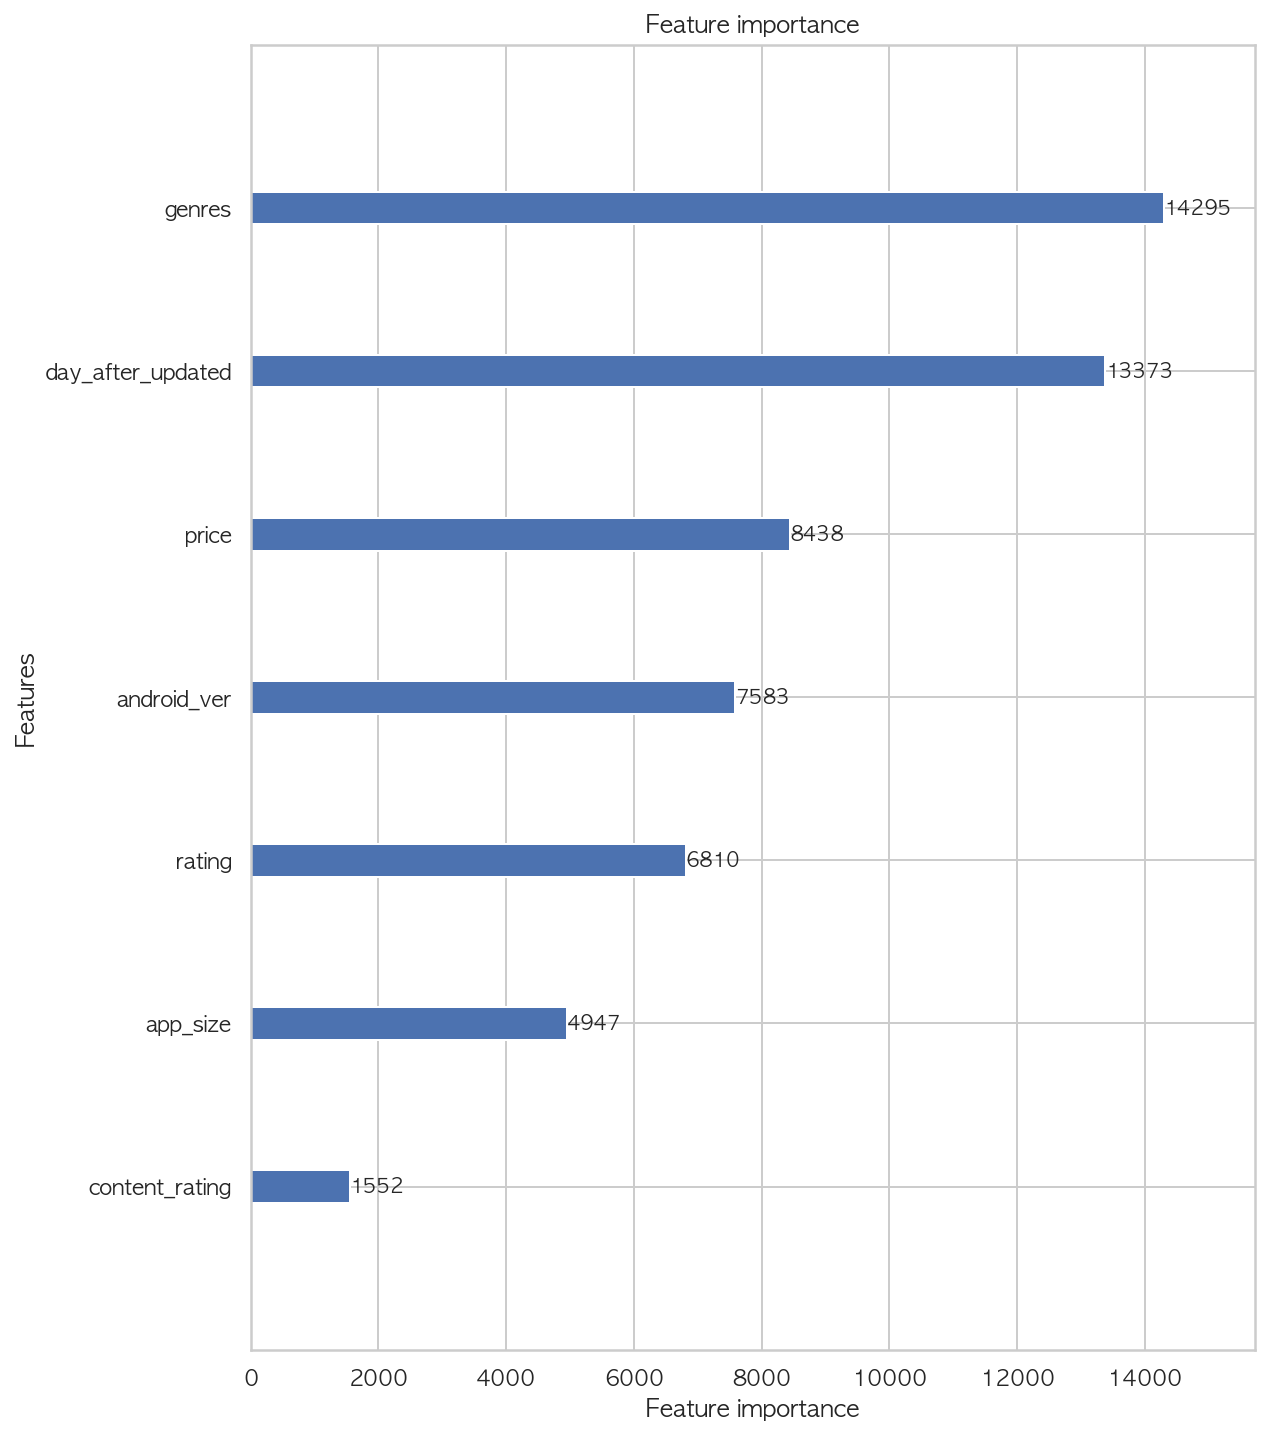

In [59]:
lgb.plot_importance(gbm, importance_type='split', figsize=(9, 12))

>Feature 중 `genres`가 가장 높은 Feature importance 수치를 나타냈습니다. Random forest regressor와 달리 `day_after_updated`보다 `genres`의 중요도가 약간 더 높습니다.

# Conclusion

Random forest regressor 모델이 약 **0.927**의 metric score로 가장 우수한 성능을 나타냈습니다. 개인적인 소견으로 Boosting model보다 Random forest model이 더 좋은 성능이 나온 이유 중 하나는 훈련에 쓰인 데이터의 양이 충분하지 못했기 때문인 것으로 생각됩니다. Sample의 수가 한정되어 있는 상황에서 조금이라도 결과를 향상시키기 위해서는 Bias 보다는 Varience의 불안정함을 해결하는 것이 우선적인 과제가 될 것 같습니다.